In [1]:
import numpy as np

from triqs.gf import *

from itertools import product

from triqs.plot.mpl_interface import oplot, plt

In [3]:
class GWSolver():
    def __init__(self,
                 g0_w, V, self_interactions = False,
                 hartree_flag = False, fock_flag = False,
                 mu = 0, N_fix = None):
        
        self.self_interactions, self.hartree_flag, self.fock_flag = self_interactions, hartree_flag, fock_flag
        self.mu = mu

        if isinstance(g0_w, BlockGf):
            self.block_struct = True
            self.blocks = [name for name, g in g0_w]
            self.target_shape = g0_w[self.blocks[0]][Idx(0)].shape

            self.N_fix = N_fix
        else: 
            self.block_struct = False
            self.target_shape = g0_w[Idx(0)].shape

            if N_fix is not None:
                self.N_fix = N_fix // 2
            else:
                self.N_fix = N_fix


        self.mu, self.g0_w = self.greenFunction(g0_w, N_fix = self.N_fix)
        self.g0_t = make_gf_from_fourier(self.g0_w)


        self.fmesh = self.g0_w.mesh
        self.beta = self.fmesh.beta
        self.nw = len(list(self.fmesh))
        self.bmesh = MeshImFreq(self.beta, 'Boson', self.nw // 2)
        self.indices = range(self.target_shape[0])
        
        self.tensor_shape = [self.target_shape[0]] * 4
        self.reshape = [index ** 2 for index in self.target_shape]
        

        if self.block_struct:
            V_shape = Gf(mesh = self.bmesh, target_shape = self.tensor_shape)
            V_shape.data[:] = V
            self.V = BlockGf(block_list = [V_shape] * 2, name_list = self.blocks, make_copies = False)


        else: 
            self.V  = Gf(mesh = self.bmesh, target_shape = self.tensor_shape)
            self.V.data[:] = V

        self.P_w = self.polarization(self.g0_t)
        
        if not self.block_struct:
            self.W_w = self.screenedPotential2(self.V, 2 * self.P_w)
        else:
            self.W_w = self.screenedPotential2(self.V, self.P_w)

        self.rho_w = self.density(self.g0_w)
        self.sigma_w = self.selfEnergy(self.g0_t, self.W_w)

        
        if self.hartree_flag:
            self.hartree = self.hartree(self.V, self.rho_w)
            self.sigma_w += self.hartree
        else:
            self.hartree = 0

        if self.fock_flag and self.self_interactions:
            self.fock = self.fock(self.V, self.rho_w)
            self.sigma_w += self.fock
        else:
            self.fock = 0

        self.mu, self.g_w = self.greenFunction(self.g0_w, self.sigma_w, mu = self.mu, N_fix = self.N_fix)
        

    def polarization(self, g0_t):
        P_shape = Gf(mesh = self.bmesh, target_shape = self.tensor_shape)
        if self.block_struct:
            P_t = make_gf_from_fourier(BlockGf(block_list = [P_shape] * 2, name_list = self.blocks))
            for block in self.blocks:
                for a, b, c, d in product(self.indices, self.indices, self.indices, self.indices):
                    P_t[block].data[:, a, b, c, d] = -g0_t[block].data[:, a, c] * g0_t[block].data[::-1, d, b]
            return make_gf_from_fourier(P_t)
        else:
            P_t = make_gf_from_fourier(P_shape)
            for a, b, c, d in product(self.indices, self.indices, self.indices, self.indices):
                P_t.data[:, a, b, c, d] = -g0_t.data[:, a, c] * g0_t.data[::-1, d, b]
            return make_gf_from_fourier(P_t)
        
            
    
    def screenedPotential(self, V, P_w):
        if self.block_struct:
            W = P_w.copy()

            reshaped_block = Gf(mesh = self.bmesh, target_shape = self.reshape)
            reshaped = BlockGf(block_list = [reshaped_block] * 2, name_list = self.blocks)

            v_reshaped = reshaped.copy()
            P_reshaped = reshaped.copy()
            idm = reshaped.copy()

            size = len(list(self.bmesh))

            for block in self.blocks:
                v_reshaped[block].data[:] = V[block].data.reshape(size, *self.reshape)
                P_reshaped[block].data[:] = P_w[block].data.reshape(size, *self.reshape)
                idm[block].data[:] = np.eye(self.reshape[0])

            VP = reshaped.copy()
            for block in self.blocks:
                for spin in self.blocks:
                    VP[block] += v_reshaped[spin] * P_reshaped[spin]


            W_reshaped = (idm - VP).inverse() * v_reshaped

            for block in self.blocks:
                W[block].data[:] = W_reshaped[block].data.reshape(size, *self.tensor_shape)

            return W
        else:
            W = P_w.copy()

            reshaped = Gf(mesh = self.bmesh, target_shape = self.reshape)

            v_reshaped = reshaped.copy()
            P_reshaped = reshaped.copy()
            idm = reshaped.copy()

            size = len(list(self.bmesh))

            v_reshaped.data[:] = V.data.reshape(size, *self.reshape)
            P_reshaped.data[:] = P_w.data.reshape(size, *self.reshape)
            idm.data[:] = np.eye(self.reshape[0])


            W_reshaped = (idm - v_reshaped * P_reshaped).inverse() * v_reshaped

            
            W.data[:] = W_reshaped.data.reshape(size, *self.tensor_shape)

            return W

    def screenedPotential2(self, V, P_w):
        if self.block_struct:
            W = P_w.copy()

            reshaped_block = Gf(mesh = self.bmesh, target_shape = self.reshape)
            reshaped = BlockGf(block_list = [reshaped_block] * 2, name_list = self.blocks)

            V_reshaped = reshaped.copy()
            P_reshaped = reshaped.copy()
            idm = reshaped.copy()

            size = len(list(self.bmesh))

            for block in self.blocks:
                V_reshaped[block].data[:] = V[block].data.reshape(size, *self.reshape)
                P_reshaped[block].data[:] = P_w[block].data.reshape(size, *self.reshape)
                idm[block].data[:] = np.eye(self.reshape[0])

            full_shape = tuple(2 * shape for shape in self.reshape)
            P_full = Gf(mesh = self.bmesh, target_shape = full_shape)
            idm_full = Gf(mesh = self.bmesh, target_shape = full_shape)
            V_full = Gf(mesh = self.bmesh, target_shape = full_shape)

            up = slice(0, self.reshape[0])
            dn = slice(self.reshape[0], 2 * self.reshape[0])


            P_full.data[:, up, up] = P_reshaped['up'].data[:]
            P_full.data[:, dn, dn] = P_reshaped['dn'].data[:]

            idm_full.data[:] = np.eye(2 * self.reshape[0])

            if self.self_interactions:
                V_full.data[:, up, up] = V_reshaped['up'].data[:]
                V_full.data[:, dn, dn] = V_reshaped['dn'].data[:]
            
            V_full.data[:, up, dn] = V_reshaped['up'].data[:]
            V_full.data[:, dn, up] = V_reshaped['dn'].data[:]

            W_full = (idm_full - V_full * P_full).inverse() * V_full


            W['up'].data[:] = W_full.data[:, :self.reshape[0], :self.reshape[0]].reshape(size, *self.tensor_shape)
            W['dn'].data[:] = W_full.data[:, self.reshape[0]:, self.reshape[0]:].reshape(size, *self.tensor_shape)
            return W
        else:
            W = P_w.copy()

            reshaped = Gf(mesh = self.bmesh, target_shape = self.reshape)

            v_reshaped = reshaped.copy()
            P_reshaped = reshaped.copy()
            idm = reshaped.copy()

            size = len(list(self.bmesh))

            v_reshaped.data[:] = V.data.reshape(size, *self.reshape)
            P_reshaped.data[:] = P_w.data.reshape(size, *self.reshape)
            idm.data[:] = np.eye(self.reshape[0])


            W_reshaped = (idm - v_reshaped * P_reshaped).inverse() * v_reshaped

            
            W.data[:] = W_reshaped.data.reshape(size, *self.tensor_shape)

            return W
    
    def selfEnergy(self, g0_t, W_w):
        
        W_dynamic_t = make_gf_from_fourier(W_w - self.V * int(self.self_interactions))

        if self.block_struct:
            sigma_t = g0_t.copy()
            for block in self.blocks:
                sigma_t[block].data[:] = 0
            cpy = sigma_t.copy()

            for block in self.blocks:
                for a, b in product(self.indices, self.indices):
                    acc = cpy.copy()          
                    for c, d in product(self.indices, self.indices):
                        acc[block].data[:, a, b] += -W_dynamic_t[block].data[:, b, c, d, a] * g0_t[block].data[:, c, d]

                    sigma_t[block].data[:, a, b] = acc[block].data[:, a, b]

            return make_gf_from_fourier(sigma_t)

        else:
            sigma_t = g0_t.copy()
            sigma_t.data[:] = 0
            cpy = sigma_t.copy()


            for a, b in product(self.indices, self.indices):
                acc = cpy.copy()          
                for c, d in product(self.indices, self.indices):
                    acc.data[:, a, b] += -W_dynamic_t.data[:, b, c, d, a] * g0_t.data[:, c, d]

                sigma_t.data[:, a, b] = acc.data[:, a, b]

            return make_gf_from_fourier(sigma_t)

    def density(self, g_w):
        rho = g_w.copy()
        if self.block_struct:
            for block in self.blocks:
                rho[block].data[:] = g_w[block].density()
            return rho 
        else:
            rho.data[:] = g_w.density()
            return rho 

    def logic(self, block, spin):
        if block != spin:
            return 1
        if block == spin and self.self_interactions:
            return 1
        return 0
    
    def hartree(self, v, rho):
        if self.block_struct:
            hartree_block = Gf(mesh = self.fmesh, target_shape = self.target_shape)
            hartree = BlockGf(block_list = [hartree_block] * 2, name_list = self.blocks)
            full_hartree = hartree.copy()
            cpy = hartree.copy()

            for block in self.blocks:
                for spin in self.blocks:
                    for a, b in product(self.indices, self.indices):
                        acc = cpy.copy()          
                        for c, d in product(self.indices, self.indices):
                            acc[block].data[:-1, a, b] += self.logic(block, spin) * v[spin].data[:, d, b, c, a] * rho[spin].data[:-1, c, d]
                            acc[block].data[-1, a, b] += self.logic(block, spin) * v[spin].data[-1, d, b, c, a] * rho[spin].data[-1, c, d]

                        hartree[block].data[:, a, b] = acc[block].data[:, a, b]

            
            for block in self.blocks:
                for spin in self.blocks:
                    full_hartree[block] += hartree[spin]

            return full_hartree
        else:
            hartree = Gf(mesh = self.fmesh, target_shape = self.target_shape)
            cpy = hartree.copy()
                
            for a, b in product(self.indices, self.indices):
                acc = cpy.copy()          
                for c, d in product(self.indices, self.indices):
                    acc.data[:-1, a, b] += v.data[:, d, b, c, a] * rho.data[:-1, c, d]
                    acc.data[-1, a, b] += v.data[-1, d, b, c, a] * rho.data[-1, c, d]


                hartree.data[:, a, b] = acc.data[:, a, b]
                    
            return hartree
    
    def fock(self, v, rho):
        if self.block_struct:
            fock_block = Gf(mesh = self.fmesh, target_shape = self.target_shape)
            fock = BlockGf(block_list = [fock_block] * 2, name_list = self.blocks)
            cpy = fock.copy()

            for block in self.blocks:
                for a, b in product(self.indices, self.indices):
                    acc = cpy.copy()          
                    for c, d in product(self.indices, self.indices):
                        acc[block].data[:-1, a, b] += v[block].data[:, b, c, d, a] * rho[block].data[:-1, d, c]
                        acc[block].data[-1, a, b] += v[block].data[-1, b, c, d, a] * rho[block].data[-1, d, c]
                    fock[block].data[:, a, b] = -acc[block].data[:, a, b]

            return fock
        
        else:
            fock = Gf(mesh = self.fmesh, target_shape = self.target_shape)
            cpy = fock.copy()
                
            for a, b in product(self.indices, self.indices):
                acc = cpy.copy()          
                for c, d in product(self.indices, self.indices):
                    acc.data[:-1, a, b] += v.data[:, b, c, d, a] * rho.data[:-1, d, c]
                    acc.data[-1, a, b] += v.data[-1, b, c, d, a] * rho.data[-1, d, c]
                fock.data[:, a, b] = -acc.data[:, a, b]
                    
            return fock
   
    def N(self, g_w):
        rho = g_w.density()
        if self.block_struct:
            N = 0
            for block in self.blocks:
                N += np.sum(np.diag(rho[block].data)).real
            return N
        else:
            return np.sum(np.diag(rho.data)).real
        
    def greenFunction(self, g0_w, sigma_w = None, mu = 0, N_fix = None):
        if not N_fix:
            return mu, self.dysonEquation(g0_w, sigma_w, mu)
        else:
            def target_function(mu):
                g_w = self.dysonEquation(g0_w, sigma_w, mu)
                return self.N(g_w) - N_fix
            
            max_iter = 1000
            mu = 5
            for i in range(max_iter):
                if abs(target_function(mu)) < 0.01:
                    break
                else:
                    mu += 0.1 * np.sign(target_function(mu))
            if i == max_iter - 1: 
                print("Max iter reached in finding chemical potential.") 
            g_w = self.dysonEquation(g0_w, sigma_w, mu)
            return mu, g_w

    def dysonEquation(self, g0_w, sigma_w = None, mu = 0):
        if sigma_w is not None:
            if self.block_struct:
                g_w = g0_w.copy()
                for block in self.blocks:
                    g_w[block] = (g0_w[block].inverse() - sigma_w[block] - mu).inverse()
                return g_w
            else:
                return (g0_w.inverse() - sigma_w - mu).inverse()
        else:
            if self.block_struct:
                g_w = g0_w.copy()
                for block in self.blocks:
                    g_w[block] = (g0_w[block].inverse() - mu).inverse()
                return g_w
            else:
                return (g0_w.inverse() - mu).inverse()

In [6]:
orbitals = 2


beta = 100
nw = 1024
t = 1.0
U = 1.0

N = orbitals

iw_mesh = MeshImFreq(beta, 'Fermion', nw)


V = np.zeros([orbitals] * 4)
for i in range(orbitals):
    V[i, i, i, i] = U


tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = t
    tij[i + 1, i] = t

g_inv = Gf(mesh = iw_mesh, target_shape = np.shape(tij))
g_inv << iOmega_n + tij
g = g_inv.inverse()
g0_w = BlockGf(block_list = [g] * 2, name_list = ['up', 'dn'])

gw = GWSolver(g0_w = g0_w, V = V, self_interactions = True, N_fix = N, hartree_flag = True, fock_flag= True)
W = gw.W_w
G = gw.g_w
wb = [iw.imag for iw in W.mesh.values()]
wf = [iw.imag for iw in G.mesh.values()]

from gwsolver import GWSolver as GWSolver2

gw2 = GWSolver2(g0_w, V, N_fix = N, hartree_flag = True, fock_flag = True)
W2 = gw2.W_w
G2 = gw2.g_w

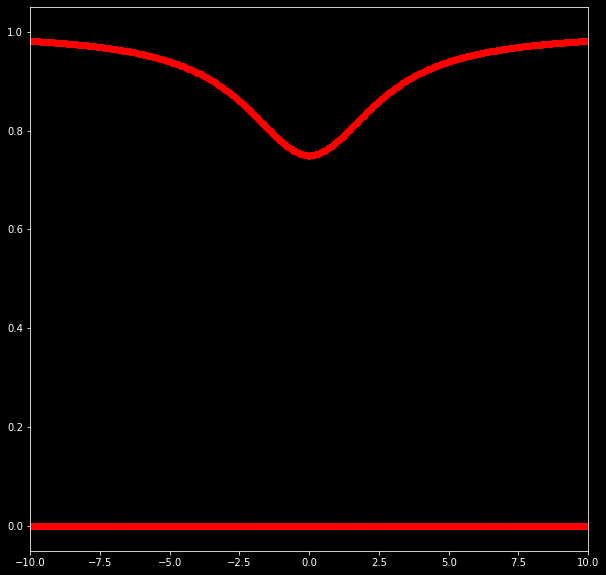

In [7]:
fig, ax = plt.subplots(1, figsize = (10, 10), facecolor = 'black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'y', colors = 'white')

ax.set_xlim(-10, 10)

ax.plot(wb, W2['up'].data[:, 0, 0, 0, 0].real, color = 'white', zorder = 0)
ax.plot(wb, W2['up'].data[:, 0, 0, 0, 0].imag, color = 'white', zorder = 0)

ax.scatter(wb, W['up'].data[:, 0, 0, 0, 0].real, color = 'red', zorder = 1)
ax.scatter(wb, W['up'].data[:, 0, 0, 0, 0].imag, color = 'red', zorder = 1)

plt.show()

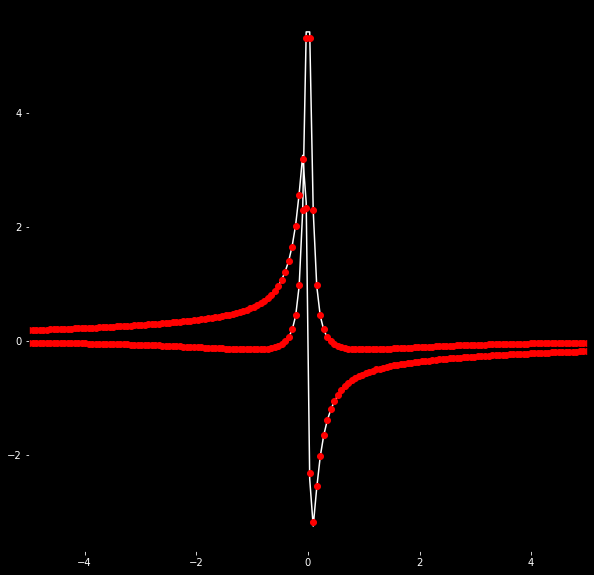

In [26]:
fig, ax = plt.subplots(1, figsize = (10, 10), facecolor = 'black')
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'y', colors = 'white')

ax.set_xlim(-5, 5)

ax.plot(wf, G2['up'].data[:, 0, 0].real, color = 'white', zorder = 0)
ax.plot(wf, G2['up'].data[:, 0, 0].imag, color = 'white', zorder = 0)

ax.scatter(wf, G['up'].data[:, 0, 0].real, color = 'red', zorder = 1)
ax.scatter(wf, G['up'].data[:, 0, 0].imag, color = 'red', zorder = 1)

plt.show()